In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

import seaborn as sns

#from sklearn.naive_bayes import MultinomialNB

In [3]:
# Loading Clean Data
df_cb = pd.read_csv("data/cleaned/cleaned_lemmatized_english.csv")#.iloc[0:30]
print("Dataset Shape:", df_cb.shape)
df_cb.head(10)

Dataset Shape: (44677, 6)


,Unnamed: 0,tweet_text,cyberbullying_type,lang,mentioned_users,hashtags
0,0,word #hashtag food crapilicious #hashtag,not_cyberbullying,en,NaN,katandandre mkr
1,1,#hashtag white #hashtag #hashtag #hashtag #has...,not_cyberbullying,en,NaN,aussietv MKR theblock ImACelebrityAU today sun...
2,2,@username classy whore red velvet cupcake,not_cyberbullying,en,XochitlSuckkks,NaN
3,3,@username meh p thanks head concern angry dude...,not_cyberbullying,en,Jason_Gio,NaN
4,4,@username isi account pretend kurdish account ...,not_cyberbullying,en,RudhoeEnglish,NaN
5,5,@username @username yes test god good bad indi...,not_cyberbullying,en,Raja5aab Quickieleaks,NaN
6,7,karma hope bite kat butt nasty #hashtag,not_cyberbullying,en,NaN,mkr
7,8,@username everything mostly priest,not_cyberbullying,en,stockputout,NaN
8,9,rebecca black drop school due bullying,not_cyberbullying,en,NaN,NaN
9,10,@username http co usqinyw5gn,not_cyberbullying,en,Jord_Is_Dead,NaN


In [4]:
print("Cyberbullying_Type Value Counts:")
print(df_cb["cyberbullying_type"].value_counts())

# Splitting the dataset by cyberbullying_types to build vocabularies
df_not = df_cb[df_cb["cyberbullying_type"] == "not_cyberbullying"]
df_religion = df_cb[df_cb["cyberbullying_type"] == "religion"]
df_age = df_cb[df_cb["cyberbullying_type"] == "age"]
df_gender = df_cb[df_cb["cyberbullying_type"] == "gender"]
df_ethn = df_cb[df_cb["cyberbullying_type"] == "ethnicity"]
df_other = df_cb[df_cb["cyberbullying_type"] == "other_cyberbullying"]
print("---------------------------------------")
print("full dataset shape: ", df_cb.shape)
print("religion shape: ", df_religion.shape)
print("age shape: ", df_age.shape)
print("gender shape: ", df_gender.shape)
print("ethnicity shape: ", df_ethn.shape)
print("other_cyberbullying shape: ", df_other.shape)
print("not_cyberbullying shape: ", df_not.shape)

Cyberbullying_Type Value Counts:
religion               7968
age                    7944
gender                 7670
ethnicity              7525
other_cyberbullying    6927
not_cyberbullying      6643
Name: cyberbullying_type, dtype: int64
---------------------------------------
full dataset shape:  (44677, 6)
religion shape:  (7968, 6)
age shape:  (7944, 6)
gender shape:  (7670, 6)
ethnicity shape:  (7525, 6)
other_cyberbullying shape:  (6927, 6)
not_cyberbullying shape:  (6643, 6)


In [5]:
# This class creates a Naive Bayes model
class NaiveBayes():
    def __init__(self):
        self.df = pd.DataFrame()
        self.df_list = []
        self.freqs = []

    # Get training dataframe used to compute model probabilities
    def print_data(self):
        return self.df
    
    # Get the model probability mappings
    def print_freqs(self):
        return(self.freqs)

    # Separate the model dataframe by cb_type
    # for building vocab frequency tables
    def split_df(self):
        # Splitting the dataset by cyberbullying_types to build vocabularies
        df = self.df
        df_not = df[df["cb_type"] == "not_cyberbullying"]
        df_religion = df[df["cb_type"] == "religion"]
        df_age = df[df["cb_type"] == "age"]
        df_gender = df[df["cb_type"] == "gender"]
        df_ethn = df[df["cb_type"] == "ethnicity"]
        df_other = df[df["cb_type"] == "other_cyberbullying"]
        # Assign 
        self.df_list = [df_not, df_religion, df_age, df_gender, df_ethn, df_other]
        return

    # Creates the vocab frequency dictionary
    # for building vocab probability dictionary
    def freq_dict(self, df):
        text = df["tweet_text"]
        vocab_freq = {}
        # Iterate over each tweet
        for tweet in text:
            words = str(tweet).split(" ")
            for word in words:
                # Check if word in vocabulary
                if word in vocab_freq:
                    # Update Frequency
                    vocab_freq[word] += 1
                else:
                    # Add word to Vocab
                    vocab_freq[word] = 1
        return vocab_freq

    # Converts vocab frequency dictionary
    # to a map between vocab and its probability
    def freq_to_prob_dict(self, vocab):
        n = np.sum(list(vocab.values()))
        for word in vocab:
            vocab[word] = vocab[word] / n
        return vocab

    # Construct all of the probability mappings
    # from a list of dataframes
    def build_freqs(self):
        freqs = []
        # Iterate each classes dataframe
        for i, df in enumerate(self.df_list):
            # Build probability mapping for each dataframe subset
            new = self.freq_to_prob_dict(self.freq_dict(df))
            self.freqs.append(new)
        return

    # Load and split training data
    # Construct probability mappings
    def fit(self, x_train, y_train):
        # Initialize Dataframe with training data
        self.df = pd.DataFrame(zip(x_train, y_train), columns=["tweet_text","cb_type"])
        # Split dataset into subsets
        self.split_df()
        # Use dataframe subsets to build respective probability mappings
        self.build_freqs()
        return

    # Compute the probability scores to compare with each other
    def get_scores(self, tweet):
        scores = np.zeros(6)
        words = str(tweet).split(" ")
        # Compute scores for each class
        for i, freq in enumerate(self.freqs):
            log_prob = np.zeros(len(words))
            # Compute log-probability of each word, given a probability mapping
            for j, word in enumerate(words):
                if word in freq:
                    log_prob[j] = np.log(freq[word])
                else:
                    log_prob[j] = np.log(0.00001)
            # Compute the sum of the log probability for a sequence of words
            scores[i] = np.sum(log_prob)
        return scores

    # Get the class corresponding to the largest score
    def get_class(self, scores):
        return np.argmax(scores)
    
    # Alternate function to get class mappings
    # as strings
    def get_class1(self, scores):
        mapping = {0.0:"not",
                   1.0:"religion",
                   2.0:"age",
                   3.0:"gender",
                   4.0:"ethn",
                   5.0:"other"}
        return mapping[np.argmax(scores)]

    # Predict the classes of the test set
    def predict(self, x_test):
        preds = []
        # Predict over a sequence of tweets
        for i, tweet in enumerate(x_test):
            scores = self.get_scores(tweet)
            preds.append(self.get_class(scores))
        return preds

Naive Bayes Accuracy: 0.7900626678603402 

[[ 630   84   25  184   14  282]
 [  67 1455    4   14   36   33]
 [ 113   11 1496   10   20   66]
 [  67   15    2 1195    1   67]
 [  58   10    6   33 1447   73]
 [ 420   18    7  124   12  837]] 



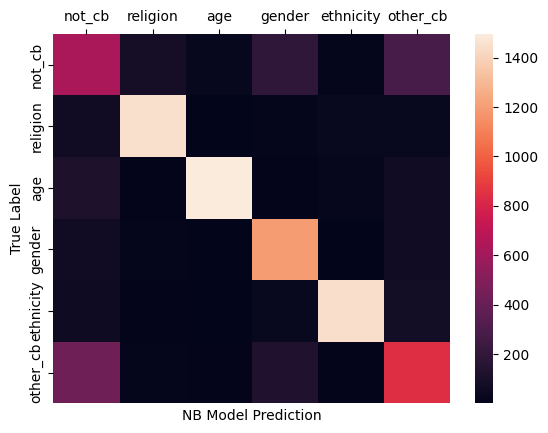

In [9]:
# Splitting the dataset
# Processing Map for labels
mapping = {"not":0.0,
           "not_cyberbullying":0.0,
           "religion":1.0,
           "age":2.0,
           "gender":3.0,
           "ethnicity":4.0,
           "ethn":4.0,
           "other_cyberbullying":5.0,
           "other":5.0}

# Split Training and Testing Data
x_train, x_test, y_train, y_test = train_test_split(df_cb['tweet_text'], df_cb["cyberbullying_type"],
                                                    shuffle=True, test_size=0.2)
# Init NB Model
model = NaiveBayes()
# Construct model probability maps
model.fit(x_train, y_train)
# Predict on the test set
predictions = model.predict(x_test)

# Format y_test to numeric categories
y = np.zeros(len(y_test))
for i, label in enumerate(y_test):
    y[i] = mapping[label]

# Compute model accuracy
correct = np.zeros(len(y))
for i, (pred, label) in enumerate(zip(predictions, y)):
    if pred == label:
        correct[i] = 1
    else:
        correct[i] = 0
print("Naive Bayes Accuracy:", np.sum(correct) / len(correct), '\n')


# Generate Confusion Matrix
cm = confusion_matrix(predictions, y)
print(cm, '\n')
ax = sns.heatmap(cm, xticklabels=["not_cb", "religion", "age", "gender", "ethnicity", "other_cb"],
                yticklabels=["not_cb", "religion", "age", "gender", "ethnicity", "other_cb"])
ax.set(xlabel="NB Model Prediction", ylabel="True Label")
ax.xaxis.tick_top()